# UCI mHealth Classification - LSTM
- https://archive.ics.uci.edu/dataset/319/mhealth+dataset

#### 데이터 구조
- 10명의 참가자별로 mHealth_subject<SUBJECT_ID>.log 파일 존재
- 가속도, 자이로, 자기장, 심전도 -> 총 23개의 feature

#### 라벨
0. Other
1. Standing still
2. Sitting and relaxing
3. Lying down
4. Walking
5. Climbing stairs
6. Waist bends forward
7. Frontal elevation of arms
8. Knees bending (crouching)
9. Cycling
10. Jogging
11. Running
12. Jump front & back


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
base_dir = "/content/drive/MyDrive/AI_data/MHEALTHDATASET"
dfs = []
col_names = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
    'ecg1', 'ecg2',
    'acc_left_ankle_x', 'acc_left_ankle_y', 'acc_left_ankle_z',
    'gyro_left_ankle_x', 'gyro_left_ankle_y', 'gyro_left_ankle_z',
    'magnet_left_ankle_x', 'magnet_left_ankl6e_y', 'magnet_left_ankle_z',
    'acc_right_arm_x', 'acc_right_arm_y', 'acc_right_arm_z',
    'gyro_right_arm_x', 'gyro_right_arm_y', 'gyro_right_arm_z',
    'magnet_right_arm_x', 'magnet_right_arm_y', 'magnet_right_arm_z',
    'label', 'subject'
]

for i in range(1, 11):
    path = os.path.join(base_dir, f"mHealth_subject{i}.log")
    df_i = pd.read_csv(path, sep='\t', header=None)
    df_i['subject'] = i
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(how='any', axis=0)
df.columns = col_names
df

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z,label,subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-4.5781,0.187760,-0.449020,-1.01030,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.449020,-1.01030,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.449020,-1.01030,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.456860,-1.00820,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.456860,-1.00820,0.025862,-0.53684,0.175900,-1.095500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.7849,-9.8287,0.29725,-0.341370,-0.90056,...,-8.9071,0.294230,0.041176,-0.99384,-0.480600,2.40890,7.496100,7.915500,0,10
1215741,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.8687,-9.8766,0.46236,-0.341370,-0.90056,...,-8.7455,0.448140,0.041176,-0.99384,-0.480600,1.69450,7.866000,7.897500,0,10
1215742,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.6928,-9.9290,0.16631,-0.341370,-0.90056,...,-9.1155,0.450480,0.041176,-0.99384,-0.480600,1.15770,8.052800,7.884900,0,10
1215743,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.5279,-9.6306,0.30458,-0.341370,-0.90056,...,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0.27441,9.487900,5.325800,0,10


In [5]:
df.label.value_counts()

,count
label,
0,872550
1,30720
2,30720
3,30720
4,30720
9,30720
5,30720
11,30720
10,30720


In [6]:
# downsampling
from sklearn.utils import resample

df_majority = df[df.label==0]
df_minorities = df[df.label!=0]

df_majority_downsampled = resample(df_majority, n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.label.value_counts()

,count
label,
1,30720
3,30720
2,30720
4,30720
9,30720
11,30720
5,30720
10,30720
0,30000


In [7]:
# df.to_csv('/content/drive/MyDrive/AI_data/MHEALTHDATASET/mhealth_resampled_data.csv',index = False)


In [8]:
df.isnull().sum()

,0
acc_chest_x,0
acc_chest_y,0
acc_chest_z,0
ecg1,0
ecg2,0
acc_left_ankle_x,0
acc_left_ankle_y,0
acc_left_ankle_z,0
gyro_left_ankle_x,0
gyro_left_ankle_y,0


### 데이터 분할
- 시계열 데이터는 시간의 흐름이 중요
- train_test_split()를 사용하면 데이터가 랜덤으로 섞임, 시간 순서가 깨져 미래 데이터가 학습에 섞여 과적합
- 피험자 단위로 분리하여 일반화 성능 측정

In [9]:
# 피험자 1-6: 훈련, 피험자 7-8: 검증, 피험자 8-9: 테스트
train = df[~df['subject'].isin([7, 8, 9, 10])]
val = df[df['subject'].isin([7, 8])]
test = df[df['subject'].isin([9, 10])]

train.shape, val.shape, test.shape

((226128, 25), (73326, 25), (73741, 25))

In [10]:
X_train = train.drop(['label','subject'], axis=1)
y_train = train['label']

X_val = val.drop(['label','subject'], axis=1)
y_val = val['label']

X_test = test.drop(['label','subject'], axis=1)
y_test = test['label']

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((226128, 23), (226128,), (73326, 23), (73326,), (73741, 23), (73741,))

In [11]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(sc.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(sc.fit_transform(X_test), columns=X_train.columns)

X_train

,acc_chest_x,acc_chest_y,acc_chest_z,ecg1,ecg2,acc_left_ankle_x,acc_left_ankle_y,acc_left_ankle_z,gyro_left_ankle_x,gyro_left_ankle_y,...,magnet_left_ankle_z,acc_right_arm_x,acc_right_arm_y,acc_right_arm_z,gyro_right_arm_x,gyro_right_arm_y,gyro_right_arm_z,magnet_right_arm_x,magnet_right_arm_y,magnet_right_arm_z
0,-0.087384,-0.180627,-0.786215,0.007915,-0.011472,-0.577582,0.733111,0.855263,0.283638,-0.578020,...,-0.402525,-0.878509,-0.115785,0.092842,-1.287582,0.881529,-0.227001,0.355856,-0.757309,0.065910
1,-0.328788,-0.300078,0.605666,-0.081073,-0.087624,-0.048897,-0.100417,0.083515,-0.577486,-0.415903,...,0.011245,0.142070,-0.403044,0.292032,-1.181228,-0.788334,-0.017597,-0.007098,-0.073927,-0.046895
2,0.241808,0.040644,-0.641235,0.070732,-0.107931,0.010368,0.093603,-0.501927,-0.867129,0.049140,...,0.540380,0.419364,-0.149160,-0.108985,-0.159630,-0.799296,-1.414959,-0.118250,-0.093139,-0.227639
3,-0.354832,-0.009466,0.177121,-0.447507,-1.224823,-0.497284,-0.085610,0.353416,-1.442512,-0.458564,...,-0.030661,0.347123,-0.554803,-0.268771,0.292298,-1.000270,-1.567971,0.008544,-0.094608,-0.020982
4,0.244441,0.152781,-0.843392,-0.332342,-0.184085,-1.151754,-0.146134,-0.361905,1.782740,0.484325,...,2.124397,-0.463871,-0.334905,-0.028403,-0.584985,-0.481392,0.522008,0.201140,0.141492,-0.024674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226123,-0.998367,0.135213,-0.547845,-0.248588,-0.544528,-0.299251,-0.707677,0.882140,-0.432654,-0.603626,...,0.449349,-0.424959,-0.777297,0.256151,-0.190019,-1.164606,-0.086059,-0.832750,-0.733695,-0.744858
226124,-1.148293,0.104779,-0.661009,-0.180527,-0.544528,0.232369,-0.590383,0.757580,-0.432654,-0.603626,...,0.287044,-0.667105,-1.022036,0.412414,-0.190019,-1.164606,-0.086059,-0.891081,-1.279427,-0.798790
226125,-1.076286,0.134339,-1.033485,-0.107247,-0.534377,1.156834,-0.723743,0.356439,-0.432654,-0.603626,...,0.031366,-0.789524,-1.428916,0.539305,-0.190019,-1.164606,-0.086059,-0.798699,-2.073697,-0.786247
226126,-0.955557,0.620911,-1.302284,0.002681,-0.427768,0.927660,-0.718710,-0.643712,-0.354383,-0.629232,...,0.009413,-0.565365,-1.578079,0.372380,-0.190019,-1.164606,-0.086059,-0.468607,-2.871990,-0.626123


### create_dataset
- X에 dataframe을 입력 -> 여러 개의 columns
- x.shape이 (time_steps, n_features)이기 때문에 Xs.shape은 (n_samples, time_steps, n_features). 따라서 reshape이 필요 없음
- ys: 윈도우 내 최빈값을 라벨로 설정, 1D 리스트
- sklearn, keras에서 y를 (n_samples, 1) 형태로 사용하기 때문에 reshape

In [12]:
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [13]:
TIME_STEPS = 200
STEPS = 40

X_train ,y_train = create_dataset(X_train, y_train, TIME_STEPS, STEPS)
X_val, y_val = create_dataset(X_val, y_val, TIME_STEPS, STEPS)
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS, STEPS)

print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Test sequences: {X_test.shape}")

Training sequences: (5649, 200, 23)
Validation sequences: (1829, 200, 23)
Test sequences: (1839, 200, 23)


## Model 1
- LSTM layer 2

In [14]:
input_shape = (200, 23)
num_classes = 13

model = Sequential([
            Input(shape=input_shape), # time_steps, n_features
            LSTM(128, return_sequences=True, dropout=0.2),
            LSTM(64, dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 128)       │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,741 (506.80 KB)

 Trainable params: 129,741 (506.80 KB)

 Non-trainable params: 0 (0.00 B)

None


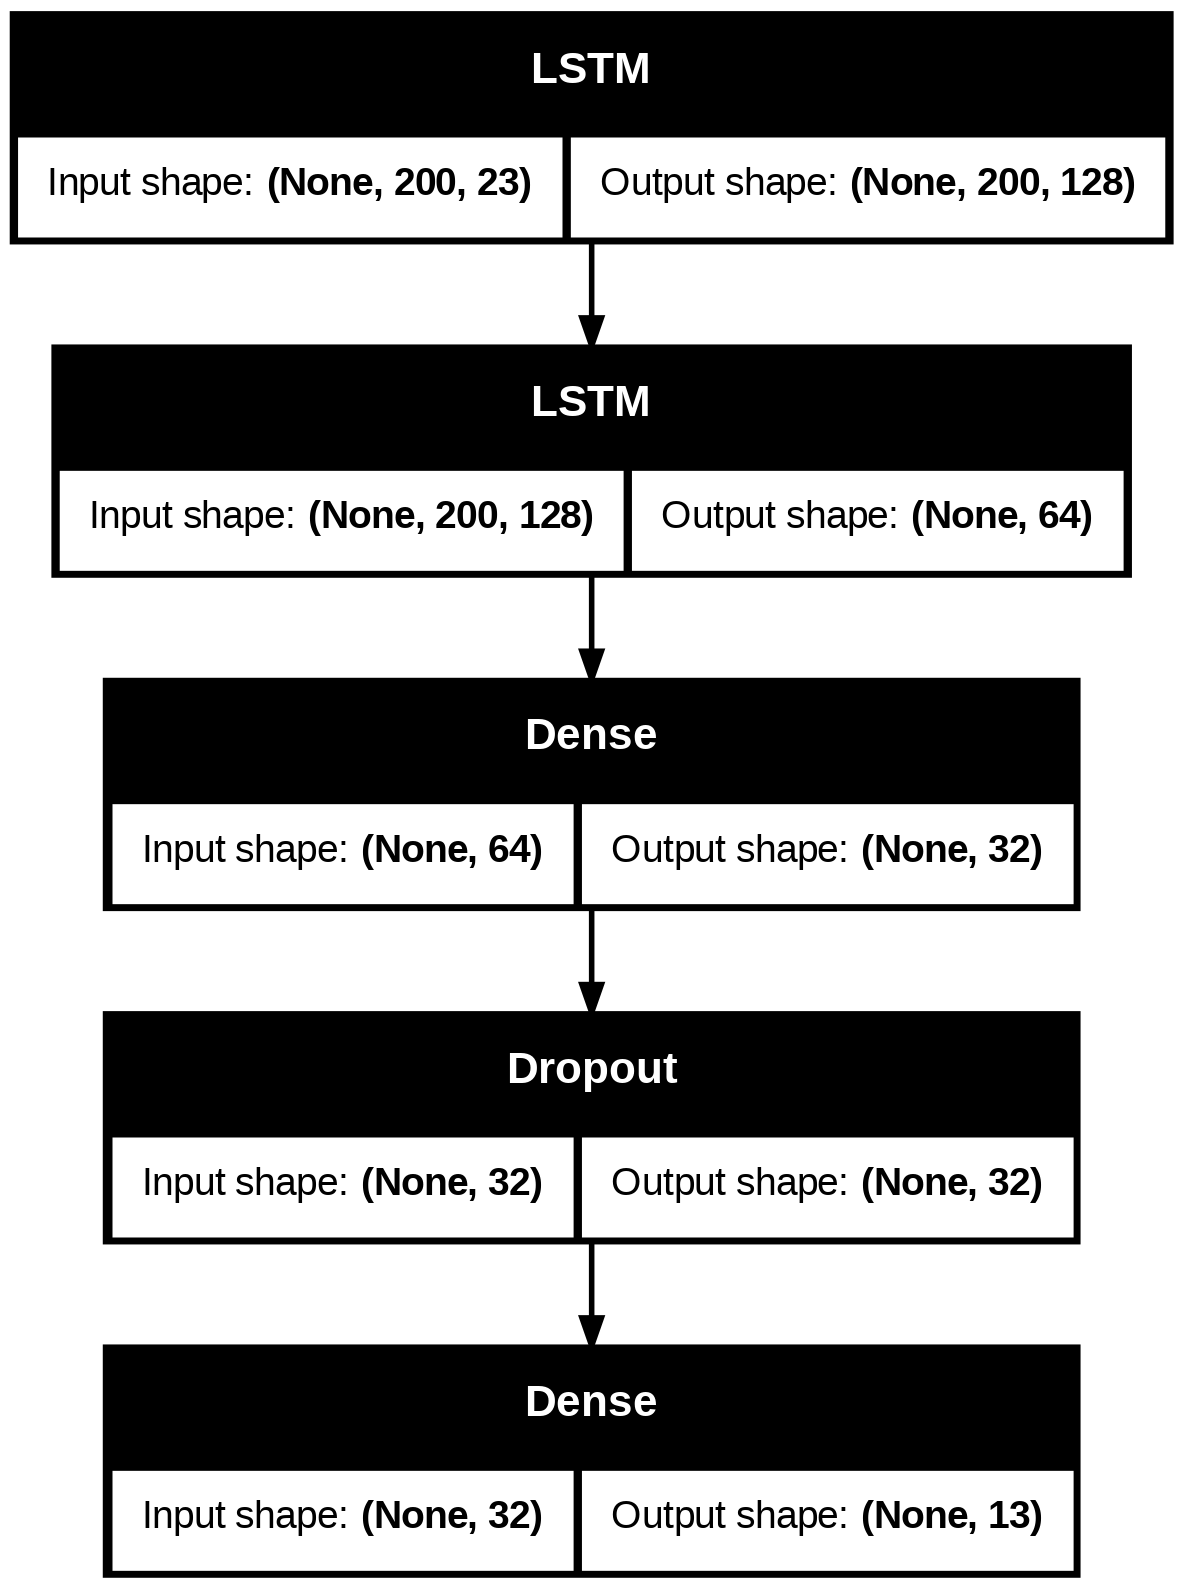

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
callbacks = [
            ModelCheckpoint(
                "mhealth_LSTM_best.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [17]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8932 - sparse_categorical_accuracy: 0.3813
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.53417, saving model to mhealth_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 1.8857 - sparse_categorical_accuracy: 0.3838 - val_loss: 1.5065 - val_sparse_categorical_accuracy: 0.5342
Epoch 2/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9739 - sparse_categorical_accuracy: 0.7049
Epoch 2: val_sparse_categorical_accuracy improved from 0.53417 to 0.71460, saving model to mhealth_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9725 - sparse_categorical_accuracy: 0.7051 - val_loss: 1.1315 - val_sparse_categorical_accuracy: 0.7146
Epoch 3/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8635 - sparse_categorical_accuracy: 0.7385
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.71460
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8666 - sparse_categorical_accuracy: 0.7379 - val_loss: 1.4587 - val_sparse_categorical_accuracy: 0.5128
Epoch 4/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2362 - sparse_categorical_accuracy: 0.6207
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.71460
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.2324 - sparse_categorical_accuracy: 0.6219 - val_loss: 1.0907 - val_sparse_categorical_accuracy: 0.6676
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0909 - sparse_categorical_accuracy: 0.6565
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.71460
1

177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8428 - sparse_categorical_accuracy: 0.7360 - val_loss: 0.9332 - val_sparse_categorical_accuracy: 0.7408
Epoch 7/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7148 - sparse_categorical_accuracy: 0.7927
Epoch 7: val_sparse_categorical_accuracy improved from 0.74084 to 0.77146, saving model to mhealth_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.7165 - sparse_categorical_accuracy: 0.7921 - val_loss: 0.7529 - val_sparse_categorical_accuracy: 0.7715
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6737 - sparse_categorical_accuracy: 0.8170
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.77146
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.6737 - sparse_categorical_accuracy: 0.8170 - val_loss: 1.2141 - val_sparse_categorical_accuracy: 0.5845
Epoch 9/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6818 - sparse_categorical_accuracy: 0.8001
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.77146
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.6794 - sparse_categorical_accuracy: 0.8009 - val_loss: 1.0372 - val_sparse_categorical_accuracy: 0.6905
Epoch 10/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5044 - sparse_categorical_accuracy: 0.8528
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.77146

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.5547 - sparse_categorical_accuracy: 0.8448 - val_loss: 0.8114 - val_sparse_categorical_accuracy: 0.7758
Epoch 12/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5090 - sparse_categorical_accuracy: 0.8470
Epoch 12: val_sparse_categorical_accuracy improved from 0.77583 to 0.81575, saving model to mhealth_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.5090 - sparse_categorical_accuracy: 0.8470 - val_loss: 0.5862 - val_sparse_categorical_accuracy: 0.8157
Epoch 13/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4901 - sparse_categorical_accuracy: 0.8638
Epoch 13: val_sparse_categorical_accuracy did not improve from 0.81575
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.4905 - sparse_categorical_accuracy: 0.8637 - val_loss: 0.7492 - val_sparse_categorical_accuracy: 0.7633
Epoch 14/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5741 - sparse_categorical_accuracy: 0.8504
Epoch 14: val_sparse_categorical_accuracy did not improve from 0.81575
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5739 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.9359 - val_sparse_categorical_accuracy: 0.7009
Epoch 15/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4653 - sparse_categorical_accuracy: 0.8686
Epoch 15: val_sparse_categorical_accuracy did not improve from 0.8

177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.4027 - sparse_categorical_accuracy: 0.8832 - val_loss: 0.5731 - val_sparse_categorical_accuracy: 0.8267
Epoch 21/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4198 - sparse_categorical_accuracy: 0.8688
Epoch 21: val_sparse_categorical_accuracy did not improve from 0.82668
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.4191 - sparse_categorical_accuracy: 0.8691 - val_loss: 0.6852 - val_sparse_categorical_accuracy: 0.7846
Epoch 22/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3456 - sparse_categorical_accuracy: 0.9068
Epoch 22: val_sparse_categorical_accuracy improved from 0.82668 to 0.83762, saving model to mhealth_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.3469 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.6015 - val_sparse_categorical_accuracy: 0.8376
Epoch 23/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3609 - sparse_categorical_accuracy: 0.9044
Epoch 23: val_sparse_categorical_accuracy did not improve from 0.83762
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.3608 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.5566 - val_sparse_categorical_accuracy: 0.8261
Epoch 24/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3307 - sparse_categorical_accuracy: 0.9161
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.83762
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.3329 - sparse_categorical_accuracy: 0.9153 - val_loss: 1.1131 - val_sparse_categorical_accuracy: 0.6834
Epoch 25/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4020 - sparse_categorical_accuracy: 0.8860
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.8

177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2604 - sparse_categorical_accuracy: 0.9261 - val_loss: 0.5028 - val_sparse_categorical_accuracy: 0.8737
Epoch 31/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9439
Epoch 31: val_sparse_categorical_accuracy improved from 0.87370 to 0.91416, saving model to mhealth_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2235 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.3660 - val_sparse_categorical_accuracy: 0.9142
Epoch 32/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2144 - sparse_categorical_accuracy: 0.9341
Epoch 32: val_sparse_categorical_accuracy did not improve from 0.91416
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9342 - val_loss: 0.2987 - val_sparse_categorical_accuracy: 0.8999
Epoch 33/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1918 - sparse_categorical_accuracy: 0.9442
Epoch 33: val_sparse_categorical_accuracy improved from 0.91416 to 0.95845, saving model to mhealth_LSTM_best.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1917 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.1601 - val_sparse_categorical_accuracy: 0.9584
Epoch 34/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1755 - sparse_categorical_accuracy: 0.9597
Epoch 34: val_sparse_categorical_accuracy did not improve from 0.95845
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1757 - sparse_categorical_accuracy: 0.9597 - val_loss: 0.9215 - val_sparse_categorical_accuracy: 0.8163
Epoch 35/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2523 - sparse_categorical_accuracy: 0.9382
Epoch 35: val_sparse_categorical_accuracy did not improve from 0.95845
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2518 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.2366 - val_sparse_categorical_accuracy: 0.9207
Epoch 36/100
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2893 - sparse_categorical_accuracy: 0.9170
Epoch 36: val_sparse_categorical_accuracy did not improve from 0.9

In [18]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_LSTM_best.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 99.01%
Training loss: 0.0346
Validation accuracy: 95.84%
Validation loss: 0.1601


In [19]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_seq = y_test.flatten()

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9714    0.9855       140
           1     0.9870    0.9870    0.9870       154
           2     0.8941    0.4935    0.6360       154
           3     0.9935    1.0000    0.9967       153
           4     0.9806    0.9870    0.9838       154
           5     0.9744    0.9870    0.9806       154
           6     0.9850    0.9850    0.9850       133
           7     0.6406    0.9858    0.7765       141
           8     0.9506    0.5274    0.6784       146
           9     0.7238    0.9935    0.8375       153
          10     0.9872    1.0000    0.9935       154
          11     1.0000    0.9870    0.9935       154
          12     0.9800    1.0000    0.9899        49

    accuracy                         0.9108      1839
   macro avg     0.9305    0.9157    0.9095      1839
weighted avg     0.9286    0.9108    0.9054      1839



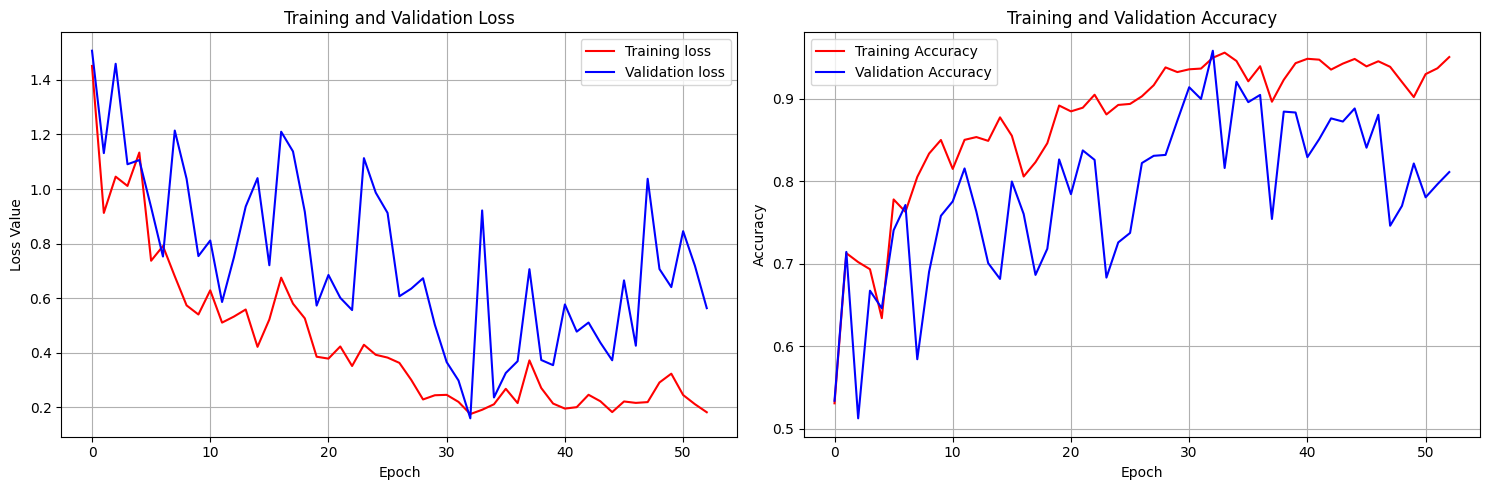

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

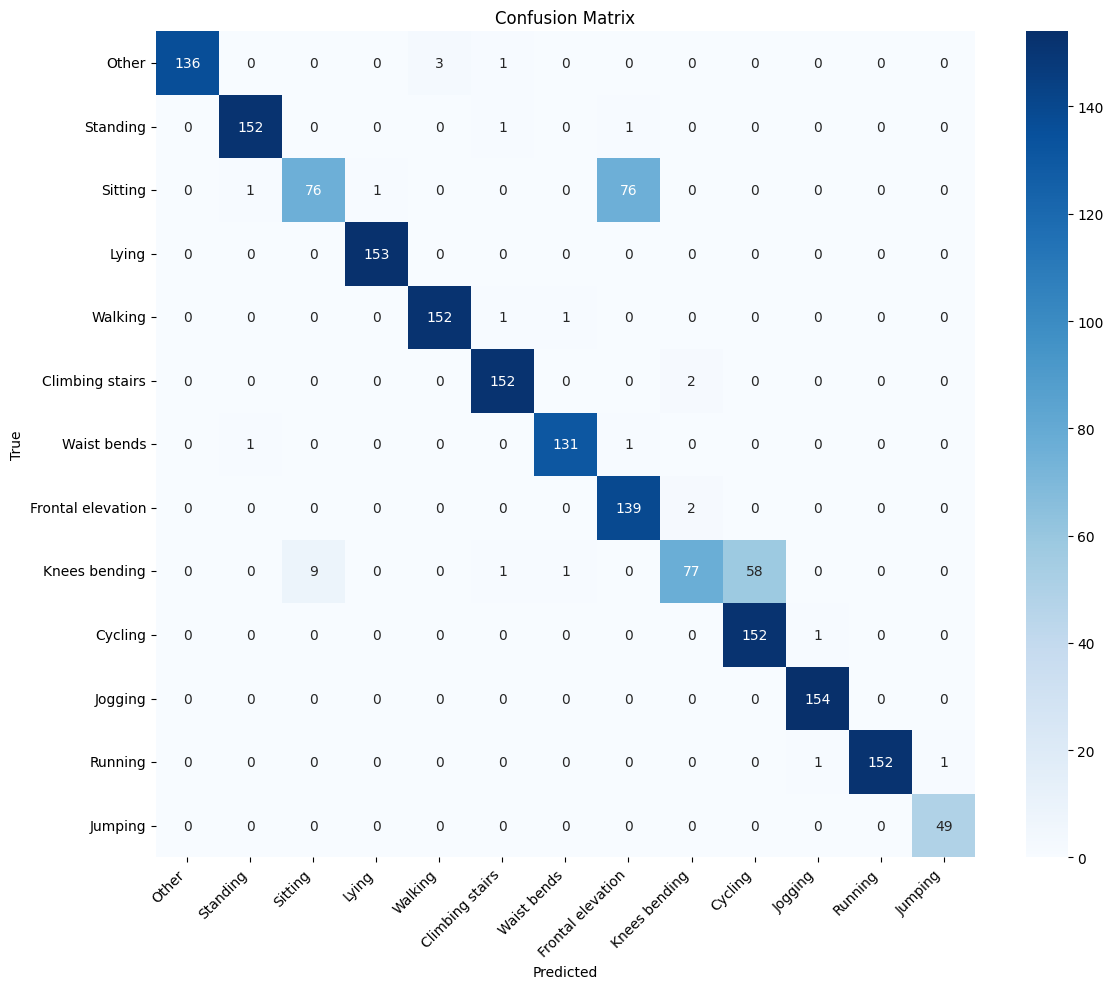

In [21]:
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test_seq))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- LSTM layer 3

In [22]:
input_shape = (200, 23)
num_classes = 13

model = Sequential([
            Input(shape=input_shape), # time_steps, n_features
            LSTM(128, return_sequences=True, dropout=0.2),
            LSTM(128, return_sequences=True, dropout=0.2),
            LSTM(64, dropout=0.2),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 200, 128)       │        77,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,325 (1020.80 KB)

 Trainable params: 261,325 (1020.80 KB)

 Non-trainable params: 0 (0.00 B)

None


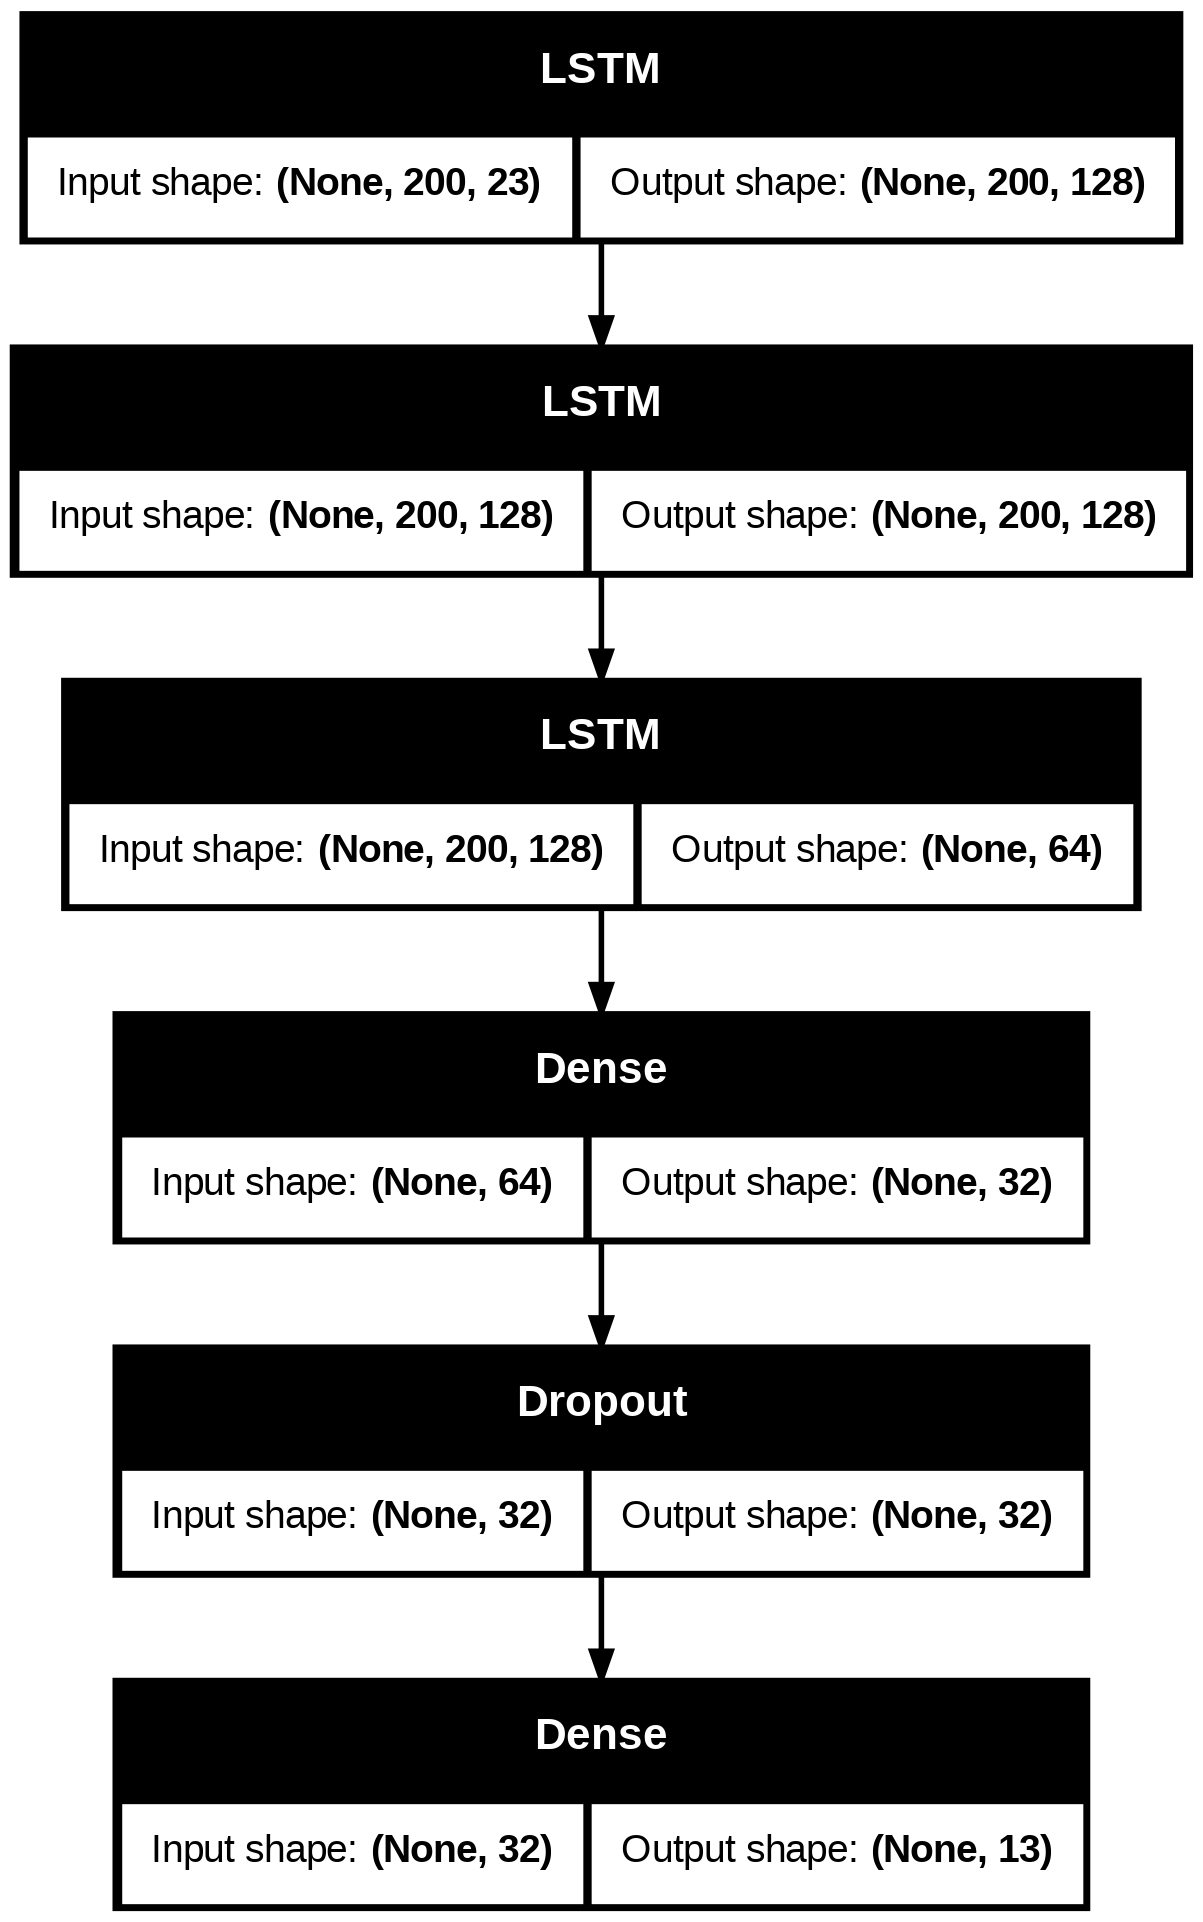

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
callbacks = [
            ModelCheckpoint(
                "mhealth_LSTM_best2.h5",
                save_best_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [25]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.7913 - sparse_categorical_accuracy: 0.4372
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.65883, saving model to mhealth_LSTM_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 1.7890 - sparse_categorical_accuracy: 0.4380 - val_loss: 1.0393 - val_sparse_categorical_accuracy: 0.6588
Epoch 2/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8888 - sparse_categorical_accuracy: 0.7474
Epoch 2: val_sparse_categorical_accuracy improved from 0.65883 to 0.76326, saving model to mhealth_LSTM_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8892 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.7873 - val_sparse_categorical_accuracy: 0.7633
Epoch 3/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.8298
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.76326
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.6590 - sparse_categorical_accuracy: 0.8299 - val_loss: 0.9187 - val_sparse_categorical_accuracy: 0.7545
Epoch 4/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4947 - sparse_categorical_accuracy: 0.8759
Epoch 4: val_sparse_categorical_accuracy improved from 0.76326 to 0.79278, saving model to mhealth_LSTM_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.4945 - sparse_categorical_accuracy: 0.8759 - val_loss: 0.6094 - val_sparse_categorical_accuracy: 0.7928
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4609 - sparse_categorical_accuracy: 0.8773
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.79278
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.4614 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.9104 - val_sparse_categorical_accuracy: 0.7715
Epoch 6/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6729 - sparse_categorical_accuracy: 0.7958
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.79278
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.6733 - sparse_categorical_accuracy: 0.7957 - val_loss: 1.0022 - val_sparse_categorical_accuracy: 0.6889
Epoch 7/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7101 - sparse_categorical_accuracy: 0.7960
Epoch 7: val_sparse_categorical_accuracy improved from 0.79278 to 0.80

177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7097 - sparse_categorical_accuracy: 0.7961 - val_loss: 0.8657 - val_sparse_categorical_accuracy: 0.8065
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7814 - sparse_categorical_accuracy: 0.7786
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.80645
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.7816 - sparse_categorical_accuracy: 0.7785 - val_loss: 1.0587 - val_sparse_categorical_accuracy: 0.6676
Epoch 9/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6640 - sparse_categorical_accuracy: 0.7959
Epoch 9: val_sparse_categorical_accuracy did not improve from 0.80645
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.6631 - sparse_categorical_accuracy: 0.7962 - val_loss: 1.0380 - val_sparse_categorical_accuracy: 0.7376
Epoch 10/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5141 - sparse_categorical_accuracy: 0.8563
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.806

177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.3943 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.2123 - val_sparse_categorical_accuracy: 0.9541
Epoch 23/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2800 - sparse_categorical_accuracy: 0.9280
Epoch 23: val_sparse_categorical_accuracy did not improve from 0.95407
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.2799 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.4644 - val_sparse_categorical_accuracy: 0.9081
Epoch 24/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2533 - sparse_categorical_accuracy: 0.9374
Epoch 24: val_sparse_categorical_accuracy did not improve from 0.95407
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2534 - sparse_categorical_accuracy: 0.9374 - val_loss: 0.5958 - val_sparse_categorical_accuracy: 0.8562
Epoch 25/100
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2304 - sparse_categorical_accuracy: 0.9415
Epoch 25: val_sparse_categorical_accuracy did not improve from 0.9

177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.1685 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.1158 - val_sparse_categorical_accuracy: 0.9661
Epoch 38/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9721
Epoch 38: val_sparse_categorical_accuracy improved from 0.96610 to 0.96884, saving model to mhealth_LSTM_best2.h5


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1260 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.1022 - val_sparse_categorical_accuracy: 0.9688
Epoch 39/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1214 - sparse_categorical_accuracy: 0.9698
Epoch 39: val_sparse_categorical_accuracy did not improve from 0.96884
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1215 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.2622 - val_sparse_categorical_accuracy: 0.9306
Epoch 40/100
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1987 - sparse_categorical_accuracy: 0.9460
Epoch 40: val_sparse_categorical_accuracy did not improve from 0.96884
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.1984 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.2402 - val_sparse_categorical_accuracy: 0.9338
Epoch 41/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1340 - sparse_categorical_accuracy: 0.9625
Epoch 41: val_sparse_categorical_accuracy did not improve from 0.

In [26]:
# 모델 평가
model = tf.keras.models.load_model("mhealth_LSTM_best2.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {test_acc * 100:.2f}%")
print(f"Validation loss: {test_loss:.4f}")

Training accuracy: 98.65%
Training loss: 0.0371
Validation accuracy: 96.88%
Validation loss: 0.1022


In [27]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_seq = y_test.flatten()

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9716    0.9786    0.9751       140
           1     0.9868    0.9740    0.9804       154
           2     0.9808    0.9935    0.9871       154
           3     1.0000    0.9804    0.9901       153
           4     0.9744    0.9870    0.9806       154
           5     0.9934    0.9805    0.9869       154
           6     0.9852    1.0000    0.9925       133
           7     1.0000    0.9929    0.9964       141
           8     0.9790    0.9589    0.9689       146
           9     0.9742    0.9869    0.9805       153
          10     0.9808    0.9935    0.9871       154
          11     0.9935    0.9935    0.9935       154
          12     0.9796    0.9796    0.9796        49

    accuracy                         0.9848      1839
   macro avg     0.9846    0.9846    0.9845      1839
weighted avg     0.9848    0.9848    0.9848      1839



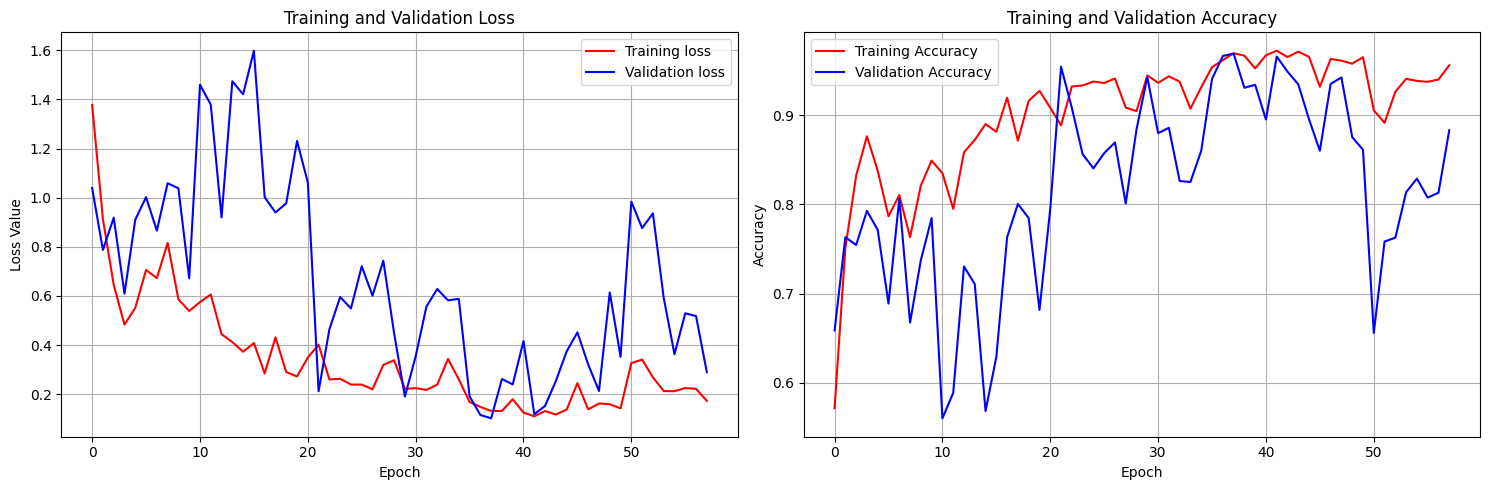

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

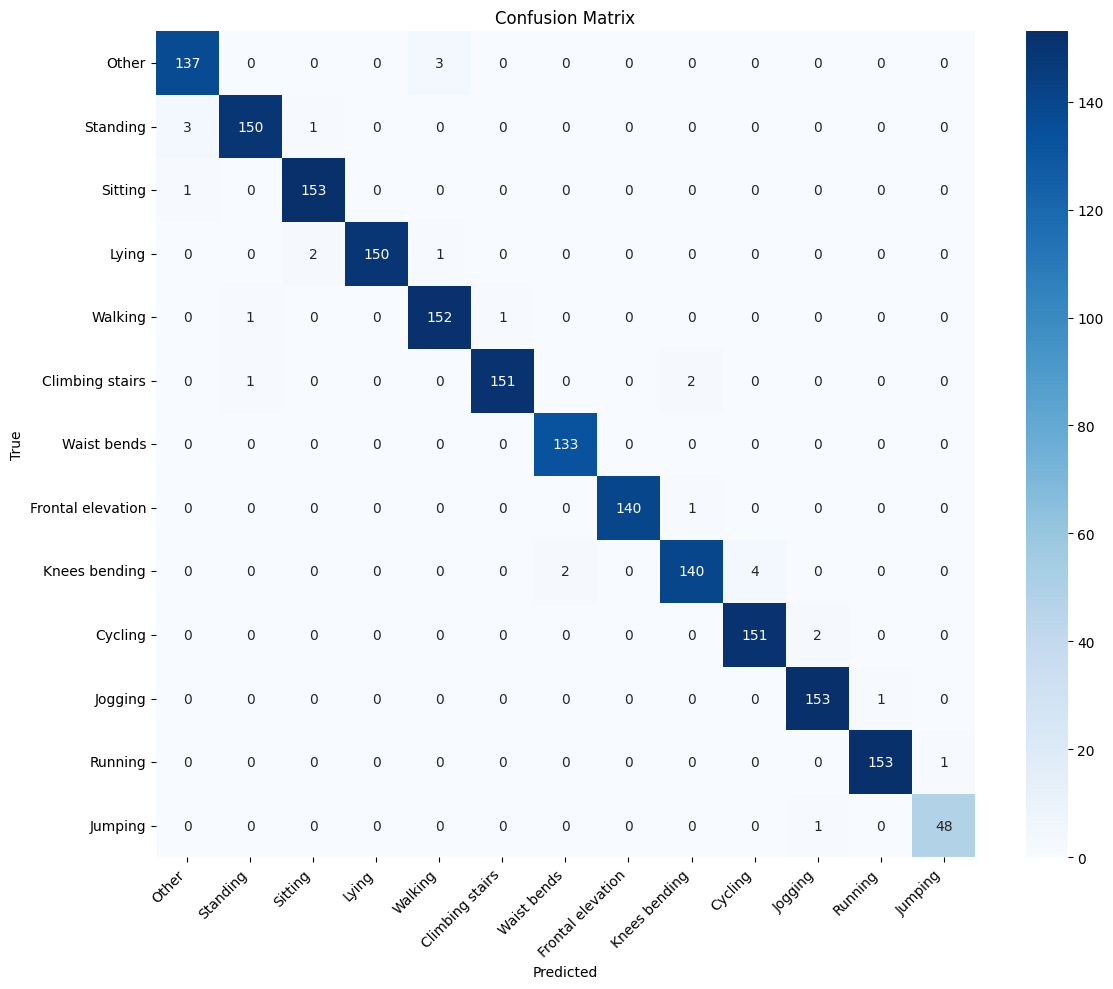

In [29]:
cm = confusion_matrix(y_test_seq, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

activity_names = [
    'Other', 'Standing', 'Sitting', 'Lying', 'Walking',
    'Climbing stairs', 'Waist bends', 'Frontal elevation',
    'Knees bending', 'Cycling', 'Jogging', 'Running', 'Jumping'
]

n_classes = len(np.unique(y_test_seq))
if n_classes <= len(activity_names):
    plt.gca().set_xticklabels(activity_names[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(activity_names[:n_classes], rotation=0)

plt.tight_layout()
plt.show()